In [1]:
# Roadmap:
# * Distributions of distances from origin to exp-map of tangent normals for K = -1, 0, 1
# * Extension to arbitrary curvatures K in (-infty, infty)
# * Extension to points away from origin

# Paying attention to:
# * Norms of points
# * Distribution of distances
# * Distribution of inner products

# at each step

In [1]:
from geomstats.geometry.hyperboloid import Hyperboloid
from geomstats.geometry.hypersphere import Hypersphere

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

INFO: Using numpy backend
INFO: NumExpr defaulting to 8 threads.


In [2]:
# Define some functions
def minkowski_inner(u, v):
    """Compute the Minkowski inner product of two vectors."""
    # Coerce vectors to 2D to get numpy array as output
    if u.ndim == 1:
        u = u[None, :]
    if v.ndim == 1:
        v = v[None, :]
    
    return np.sum(u[:, 1:] * v[:, 1:], axis=1) - u[:, 0] * v[:, 0]

def minkowski_sqnorm(x):
    """Compute the Minkowski square norm of a vector."""
    return minkowski_inner(x, x)

def get_dists_from_point(points, mu=None, K=None):
    """Get the distances of points from a point on the hyperboloid."""
    # Find the curvature if it is not given
    if K is None:
        sqnorms = minkowski_sqnorm(points)
        assert np.allclose(sqnorms, sqnorms.mean()), "Points are not on the same hyperboloid"
        K = -1/sqnorms.mean()
    
    if K < 0:
        print("Making K positive")
        K = -K

    # Find the origin if mu is None
    if mu is None:
        mu = np.zeros(points.shape[1])
        mu[0] = 1 / np.sqrt(K)
    
    # Get the distances using hyperbolic distance
    dists = np.arccosh(-minkowski_inner(points, mu) / np.sqrt(K))

    return dists

def rescale_curvature(points, K):
    """Rescale points on the hyperboloid to have curvature K."""
    sqnorms = minkowski_sqnorm(points)
    assert np.allclose(sqnorms, sqnorms.mean()), "Points are not on the same hyperboloid"
    K_old = -1/sqnorms.mean()
    points_rescaled = np.sqrt(K_old / K) * points
    return points_rescaled

In [9]:
# Test the Minkowski inner product and square norms
u = np.array([1., 0., 0.])
v = np.array([np.sqrt(3), 1., 1.])
print(1, minkowski_inner(u, v))
print(2, minkowski_sqnorm(u))
print(3, minkowski_sqnorm(v))

# Can we get square norms of a bunch of points?
points = np.array([[1., 0., 0.], [np.sqrt(3), 1., 1.]])
print(4, minkowski_sqnorm(points))

# Test the distance function
points = np.array([[1., 0., 0.], [np.sqrt(3), 1., 1.]])
dists = get_dists_from_point(points)
print(5, dists)

# Test rescale function as well
points_rescaled = rescale_curvature(points, 10)
print(6, points_rescaled, minkowski_sqnorm(points_rescaled))

1 [-1.73205081]
2 [-1.]
3 [-1.]
4 [-1. -1.]
5 [0.         1.14621583]
6 [[0.31622777 0.         0.        ]
 [0.54772256 0.31622777 0.31622777]] [-0.1 -0.1]


In [11]:
NDIM = 2
NPOINTS = 10_000

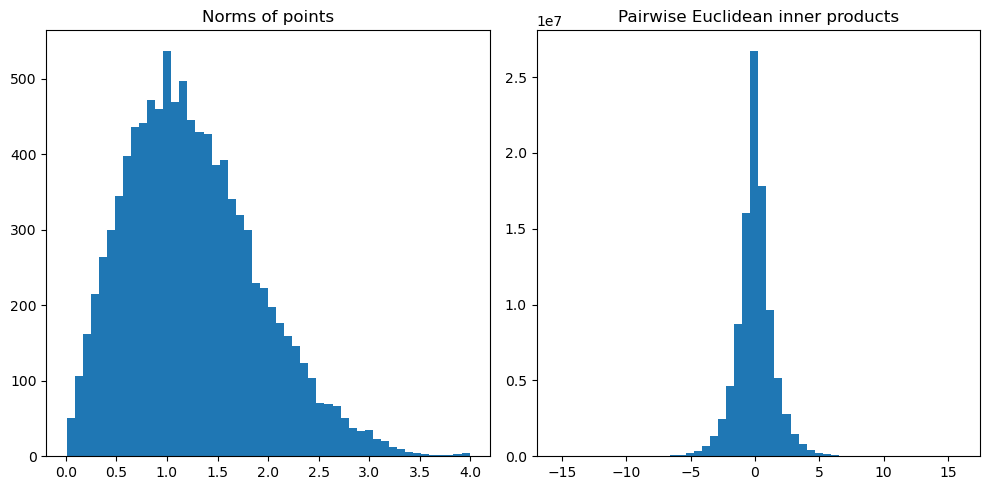

In [41]:
# Distances from origin to exp-map of tangent normals

# Define manifold
manifold = Hyperboloid(dim=NDIM)

# Get a sample of normally distributed points
X_euc = np.random.standard_normal((NPOINTS, NDIM))

# Compute stats
euc_norms = np.linalg.norm(X_euc, axis=1)
euc_dotprods = np.sum(X_euc[:, None, :] * X_euc[None, :, :], axis=2).flatten()

# Plot some stuff about the points
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(euc_norms, bins=50)
axs[0].set_title("Norms of points")

# Pairwise Euclidean inner products
axs[1].hist(euc_dotprods, bins=50)
axs[1].set_title("Pairwise Euclidean inner products")

plt.tight_layout()
plt.show()

In [42]:
# Start projecting onto the manifold

# Recall: we don't expect the exp map to be inner product preserving
# Rather, we expect that d(exp(u), mu) = ||u||_L

# Transform points to tangent plane by prepending a 1
X_tan = np.concatenate([np.ones((X_euc.shape[0], 1)), X_euc], axis=1)

tan_norms = np.linalg.norm(X_tan, axis=1)
tan_dotprods = np.sum(X_tan[:, None, :] * X_tan[None, :, :], axis=2).flatten()

# Norms are off by a factor of 1
assert np.allclose(euc_norms, np.sqrt(tan_norms**2 - 1))

# Dot products are also off by a factor of 1
assert np.allclose(euc_dotprods, tan_dotprods - 1)

In [43]:
# What about the Minkowski norms and inner products?

tan_mnorms = minkowski_sqnorm(X_tan)
tan_mdotprods = (
    np.sum(X_tan[:, None, 1:] * X_tan[None, :, 1:], axis=2) - X_tan[:, None, 0] * X_tan[None, :, 0]
).flatten()

# Minkowski norms are off by a factor of 1, but in the opposite direction
assert np.allclose(euc_norms, np.sqrt(tan_mnorms + 1))

# Minkowski inner products are off by a factor of 1, but in the opposite direction
assert np.allclose(euc_dotprods, tan_mdotprods + 1)

# Verify that X_tan lies in the tangent plane
# In our case, the tangent plane has the equation x_0 = 1
assert np.allclose(X_tan[:, 0], 1)

In [44]:
def my_expmap(points, mu):
    """z = exp_mu(u) = cosh(||u||_L)mu + sinh(||u||_L)u/||u||_L"""
    # Compute the norm of the points
    norms = minkowski_sqnorm(points)        # shouldn't there be a sqrt?
    
    # Compute the exp map
    z = np.cosh(norms)[:, None] * mu[None, :] + np.sinh(norms)[:, None] * points / norms[:, None]
    
    return z

In [47]:
# Finally we can take expmap
mu = np.zeros(NDIM+1)
mu[0] = 1.
# X_exp = manifold.metric.exp(X_tan, base_point=mu)
X_exp = my_expmap(X_tan, mu)

# Compute stats
exp_norms = minkowski_sqnorm(X_exp)
exp_dists = get_dists_from_point(X_exp)
# exp_dists = manifold.metric.dist(X_exp, mu)

assert np.allclose(exp_norms, -1)
assert np.allclose(tan_mnorms**0.5, exp_dists)

AssertionError: Points are not on the same hyperboloid

In [99]:
minkowski_sqnorm(X_exp)

array([-10.49883307, -20.59652488, -16.54574397, ..., -34.14107741,
        -8.51672905, -18.83942632])

/tmp/ipykernel_1413334/4160836742.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(tan_mnorms**0.5, bins=50)


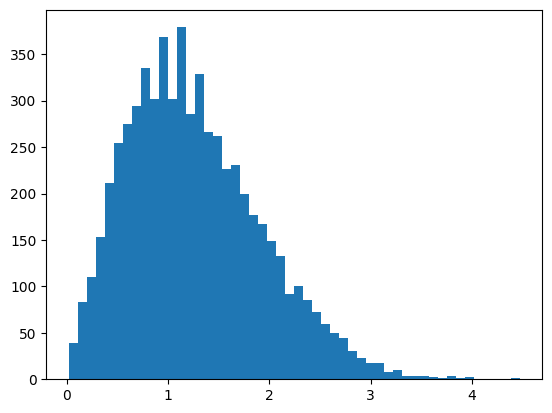

In [83]:
plt.hist(tan_mnorms**0.5, bins=50)
plt.show()

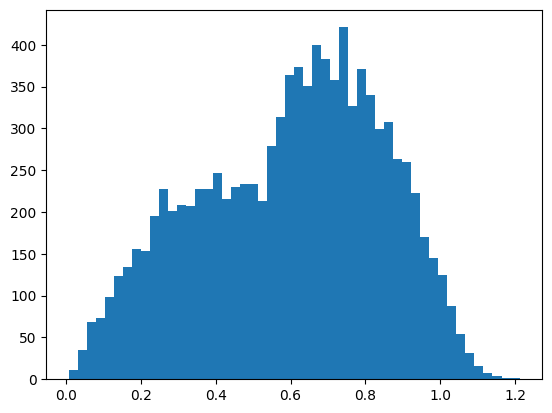

In [84]:
plt.hist(exp_dists, bins=50)
plt.show()